d:\Thesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Thesis\.venv\lib\site-packages\timm\models\helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
d:\Thesis\.venv\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
d:\Thesis\.venv\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import v

['stage1_conv_embed.0.weight', 'stage1_conv_embed.0.bias', 'stage1_conv_embed.2.weight', 'stage1_conv_embed.2.bias', 'stage1.0.qkv.weight', 'stage1.0.qkv.bias', 'stage1.0.norm1.weight', 'stage1.0.norm1.bias', 'stage1.0.proj.weight', 'stage1.0.proj.bias', 'stage1.0.attns.0.get_v.weight', 'stage1.0.attns.0.get_v.bias', 'stage1.0.attns.1.get_v.weight', 'stage1.0.attns.1.get_v.bias', 'stage1.0.mlp.fc1.weight', 'stage1.0.mlp.fc1.bias', 'stage1.0.mlp.fc2.weight', 'stage1.0.mlp.fc2.bias', 'stage1.0.norm2.weight', 'stage1.0.norm2.bias']
Predicted class: 404
Predicted class name: airliner


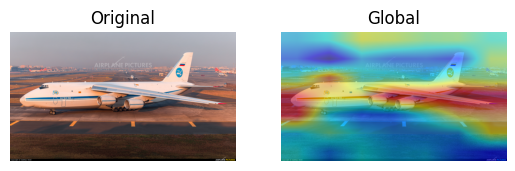

In [1]:
import torch
from timm.models import create_model
from cswinmodified import CSWin_64_12211_tiny_224  # Use the modified model
import torchvision.transforms as T
import json
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def avg_heads(cam,grad):
    # cam is the attention 
    # grad is the gradient of the said attention.
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

def apply_self_attention_rules(R_ss,cam_ss):
    R_ss_addition = torch.matmul(cam_ss,R_ss)
    return R_ss_addition

def upsample_relevance_nearest(R,old_tokens, new_tokens):
    R = R.reshape(1,1,old_tokens,old_tokens)
    R = torch.nn.functional.interpolate(R, size=(new_tokens, new_tokens), mode='bilinear')
    R = R.reshape(new_tokens, new_tokens)
    return R

def generate_relevance(model,input,index=None):
    result = model(input, register_hook=True, return_attentions=True)
    if len(result) == 5:
        output, global_attention, vertical_attention, horizontal_attention,overall_attention = result
        # Use all four
    else:
        output, global_attention = result
        # Use only two
    if index == None:
        index=np.argmax(output.cpu().data.numpy(),axis=-1)
    
    one_hot = np.zeros((1,output.size()[-1]),dtype=np.float32)
    one_hot[0, index] = 1
    one_hot_vector = one_hot
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot * output)
    model.zero_grad()
    one_hot.backward(retain_graph=True)
 
    #num_tokens = vertical_attention[-1].shape[-1]
#    else:
    num_tokens = model.stage4[0].attns[0].get_attention_map().shape[-1]

    # Initialize relevance matrices

    # Loop through all vertical/horizontal blocks (all but last stage)
    # You may need to adjust this if your model has a different number of blocks per stage
    # For the last stage (global attention)
    blk = model.stage4[-1]
    grad_g = blk.attns[0].get_attn_gradients()
    cam_g = blk.attns[0].get_attention_map()
    cam_g = avg_heads(cam_g, grad_g)
    R_global = torch.eye(num_tokens, num_tokens)
    R_global += apply_self_attention_rules(R_global, cam_g)

    # Return relevance maps for each type
    # Correct order: vertical, horizontal, global
    return  R_global.sum(dim=0) 

    # create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def get_patch_grid_size(model, img_size=224):
    # Try to get patch size from model, fallback to 4 if not present
    patch_size = getattr(model, 'patch_size', 4)
    if isinstance(patch_size, tuple):
        patch_h, patch_w = patch_size
    else:
        patch_h = patch_w = patch_size
    grid_h = img_size // patch_h
    grid_w = img_size // patch_w
    return grid_h, grid_w

def generate_visualization(original_image, class_index=None):
    # Get relevance maps for each attention type
    R_global = generate_relevance(model, original_image.unsqueeze(0), index=class_index)
    grid_h, grid_w = get_patch_grid_size(model, img_size=224)
    # Reshape and upsample for visualization
    def process_relevance(R):
        R = R.detach()
        numel = R.numel()
        # Try to find two factors (h, w) such that h * w == numel and h <= w
        best_h, best_w = 1, numel
        min_diff = numel
        for h in range(1, int(np.sqrt(numel)) + 1):
            if numel % h == 0:
                w = numel // h
                if abs(w - h) < min_diff:
                    best_h, best_w = h, w
                    min_diff = abs(w - h)
        # If not a perfect rectangle, pad to next (h, w)
        if best_h * best_w != numel:
            next_square = int(np.ceil(np.sqrt(numel))) ** 2
            pad_len = next_square - numel
            R = torch.nn.functional.pad(R, (0, pad_len))
            best_h = best_w = int(np.sqrt(next_square))
        R = R.reshape(1, 1, best_h, best_w)
        R = torch.nn.functional.interpolate(R, size=(224, 224), mode='bilinear')
        R = R.reshape(224, 224).data.cpu().numpy()
        R = (R - R.min()) / (R.max() - R.min())
        return R

    global_map = process_relevance(R_global)

    image_np = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    mask_resized = cv2.resize(global_map, (img.width, img.height))
    vis_global = show_cam_on_image(np.array(img)/255.0, mask_resized)
    #vis_global = show_cam_on_image(image_np, global_map)

    vis_global = np.uint8(255 * vis_global)

    vis_global = cv2.cvtColor(np.array(vis_global), cv2.COLOR_RGB2BGR)

    # Return in the correct order for plotting: global, vertical, horizontal
    return vis_global

def print_top_classes(predictions, **kwargs):
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

# 1. Create the model instance (do not use pretrained=True unless you want to load default weights)
model = CSWin_64_12211_tiny_224(pretrained=False)

# 2. Load the checkpoint
checkpoint = torch.load('D:/Thesis/CSWin_Transformer_main/cswin_tiny_224.pth', map_location='cpu')

# 3. Extract the state_dict (handles both plain and wrapped checkpoints)
if 'state_dict_ema' in checkpoint:
    state_dict = checkpoint['state_dict_ema']
elif 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint

# 4. Remove 'module.' prefix if present (for DataParallel checkpoints)
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace('module.', '') if k.startswith('module.') else k
    new_state_dict[new_key] = v

# 5. Load weights into the model
model.load_state_dict(new_state_dict, strict=False)  # strict=False ignores non-matching keys

print(list(state_dict.keys())[:20])  # Print first 20 keys
# 6. Set model to evaluation mode
model.eval()

# 5. (Optional) Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Load and preprocess your image
img = Image.open('D:/Thesis/airplane.jpg').convert('RGB')
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = transform(img).unsqueeze(0)  # Add batch dimension
input_tensor = input_tensor.to(device)

with torch.no_grad():
    output = model(input_tensor)
    pred = output.argmax(dim=1)
    print('Predicted class:', pred.item())

vis_global = generate_visualization(transform(img), class_index=1)

fig, axs = plt.subplots(1, 2)  # 4 subplots: original + 3 maps
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Original')

axs[1].imshow(vis_global)
axs[1].axis('off')
axs[1].set_title('Global')


# Download ImageNet class index mapping if you don't have it
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
filename = "imagenet_classes.txt"
urllib.request.urlretrieve(url, filename)

# Read the class names
with open(filename, "r") as f:
    classes = [line.strip() for line in f.readlines()]

print("Predicted class name:", classes[pred.item()])